In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### let's build a Value class to represent a single scalar value, and the operations that can be performed on it

#### Creating Computational Graphs

In [2]:
from graphviz import Digraph

def trace(root):
    # Builds sets of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build_graph(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR here means left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in graph create a rectangular ('record') node for it
        dot.node(name = uid, label = f"{{ {n.label} | data: {n.data:.4f} | grad: {n.grad:.4f} }}", shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect it to this value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connec n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

#### Creating the Vlue Class with automatic differentiation capabilities

In [3]:
# creating a value class that supports automatic differentiation

class Value:

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None # by default, do nothing
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad              # += instead of = for grad accumulation
            other.grad += 1.0 * out.grad             # += instead of = for grad accumulation

        out._backward = _backward 
        return out
    
    def __radd__(self,other):   # for the order (other + self)
        return self + other
    

    def __neg__(self):
        return self * -1

    def __sub__(self,other):
        return self + (-other)
    
    def __rsub__(self,other):   # for the order (other - self)
        return other + (-self)

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad      # += instead of = for grad accumulation
            other.grad += self.data * out.grad      # += instead of = for grad accumulation

        out._backward = _backward 
        return out
    
    def __rmul__(self,other):   # for the order (other * self)
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other, (int, float, Value)), "only supporting int/float/Value powers for now"
        if isinstance(other, Value):
            other = other.data
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad   # += instead of = for grad accumulation

        out._backward = _backward 
        return out

    def __truediv__(self,other):
        return self * other**-1        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad        # += instead of = for grad accumulation

        out._backward = _backward 
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad        # += instead of = for grad accumulation

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [4]:
# Using tanh activation function directly

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh
o = n.tanh(); o.label = 'o'
o.backward()

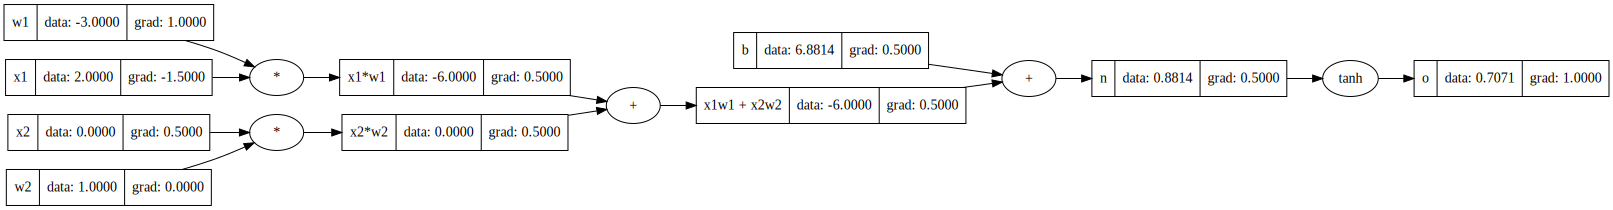

In [5]:
draw_dot(o)

In [6]:
# Applying tanh activation function by its exponential definition

# inputs of the neuron: x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron: w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron: b
b = Value(6.8813735870195432, label='b') # bias is set to 6.8813735870195432 to get output close to 1.0

# x1*w1 + x2*w2 + b (step by step)
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# applying activation function of tanh (by exponential definition)
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()

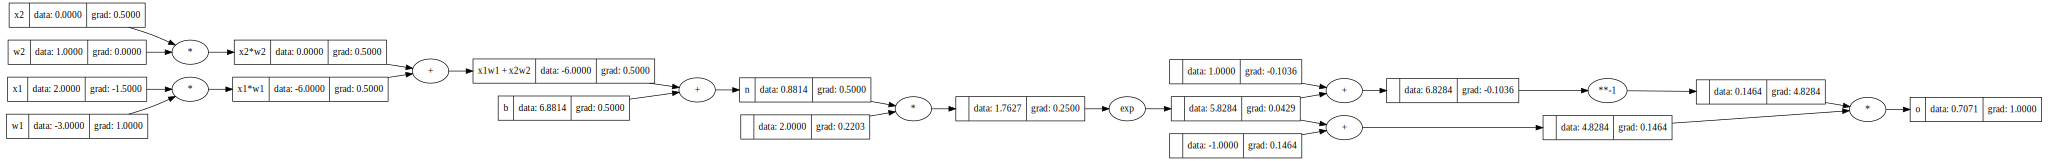

In [7]:
draw_dot(o)

## Creating a neuron class with micrograd

In [8]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()  # activation function
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [9]:
# creating a sample neuron with 2 inputs

x = [2.0, 3.0]
n = Neuron(2)
n(x)  # forward pass through the neuron

Value(data=0.5801200673564302)

## Creating a Layer class with multiple neurons in it

Now that we have a Value and a Neuron class, let's try to make a Layer class that contains multiple neurons which can be used to build a simple neural network.

In [10]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [11]:
x = [2.00 , 3.00, -1.0]
n = Layer(3,4)
n(x)  # forward pass through the layer

[Value(data=-0.8877742258876968),
 Value(data=0.4633955005178144),
 Value(data=0.9653710911380399),
 Value(data=-0.9664551626714969)]

## Creating a MLP class with multiple layers in it

In [12]:
class MLP:
    def __init__(self, nin, nouts): # nouts is a list containing number of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

So now let's try to implement the MLP architecture shown below using the MLP class we just created.

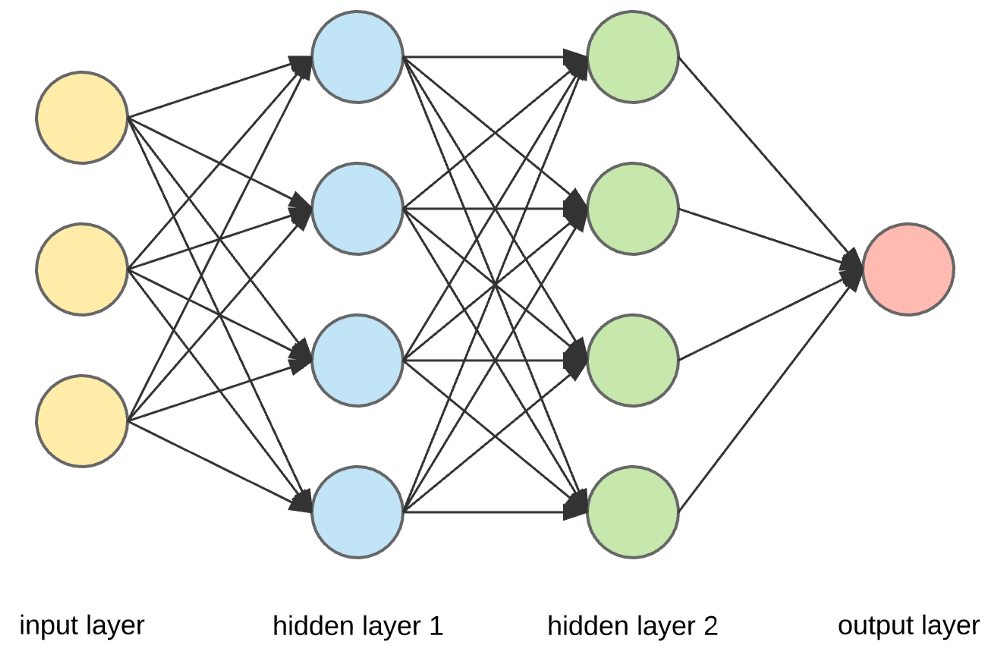


In [13]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])  # 3 inputs, 3 layers with 4,4,1 neurons respectively
n(x)  # forward pass through the MLP

Value(data=0.4335739369400443)

In [14]:
# let's create a sample dataset

xs = [
    [2.0, 3.0, -1.0],  #  1
    [3.0, -1.0, 0.5],  # -1
    [0.5, 1.0, 1.0],   # -1
    [1.0, 1.0, -1.0],  #  1
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired labels

In [15]:
# Let's see how our MLP performs on this dataset

ypred = [n(x) for x in xs]
ypred

[Value(data=0.4335739369400443),
 Value(data=0.23370654184437753),
 Value(data=0.2902796610635145),
 Value(data=0.5186973734541449)]

So as we can see the predictions don't really match the desired labels. This is because we haven't trained the network yet. And for that we'll need a loss function and a way to update the weights using backpropagation in order to minimize the said loss.

In [16]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.739344138377331)

As soon as we call loss.backward(), the gradients for all the values in the computation graph are calculated using backpropagation.
This includes the weights and biases of the neurons in our MLP.

In [17]:
loss.backward()

In [18]:
# let's looka at the gradient of first weight of first neuron of first layer
n.layers[0].neurons[0].w[0].grad 

0.4340551150280873

And now with the values of the gradients, we can update the weights and biases using gradient descent or any other optimization algorithm of our choice. And train our MLP to perform better on this dataset.

But before that we'll need the set of all the parameters in our MLP. So let's create a parameters method in our Neuron, Layers and MLP classes that returns all the parameters of the network. (Go back to these classes and check the parameters methods out)